In [1]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
!pip install awkward_pandas
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# open file
ixns = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/shower_particle_reco_based_sample.root")
#true_tracks = uproot.open("/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/pi0_reco_based_sample.root")
ixns["RecoBenchmarkTree"].show()
ixns["RecoBenchmarkTree"].keys()
ixns["RecoBenchmarkTree"][0].num_entries
#ixns["RecoBenchmarkTree"]['caf_file_name']



name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_to_vt... | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_z         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_start_x  | std::

1

In [4]:
# Set up data frame
ak_array = ixns["RecoBenchmarkTree"].arrays(library="ak")
df = ak.to_dataframe(ak_array)
df = df.reset_index(drop=True)
overlap_cut = 0.5
reco_angle_cut = 0.1
df = df[df['part_overlap'] > overlap_cut]
showers_before_angle_cut = len(df)
df = df[abs(df['reco_angle']-(np.pi/2)) < reco_angle_cut]
reco_minus_true_angle_cut = 0.5
df = df[abs(df['reco_angle'] - df['true_angle']) >= reco_minus_true_angle_cut]
df
num_entries = len(df)
print(num_entries)

4373


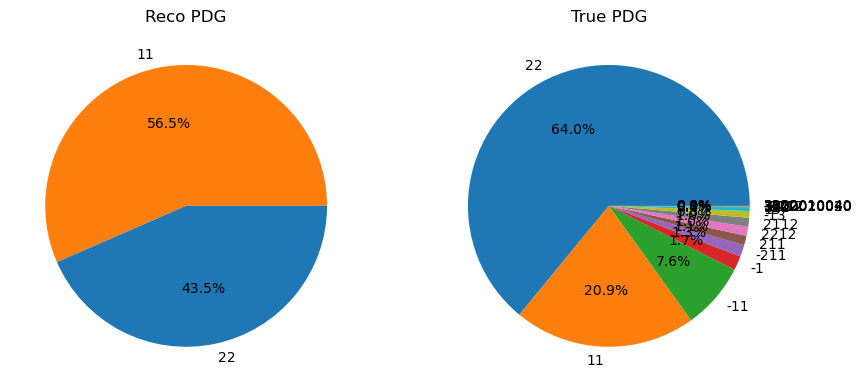

In [4]:
# Look at true vs. reco pdg
fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].pie(df['reco_pdg'].value_counts(), labels = df['reco_pdg'].value_counts().index, colors=['#ff7f0e', '#1f77b4'], autopct='%1.1f%%')
ax[0].set_title('Reco PDG')

ax[1].pie(df['true_pdg'].value_counts(), labels = df['true_pdg'].value_counts().index, autopct='%1.1f%%')
ax[1].set_title('True PDG')
plt.show()

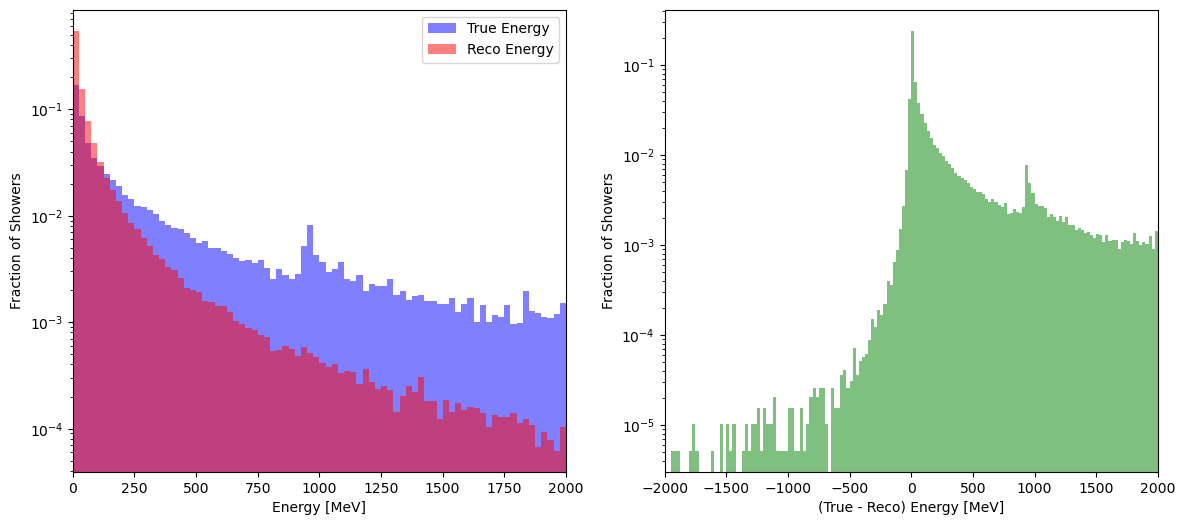

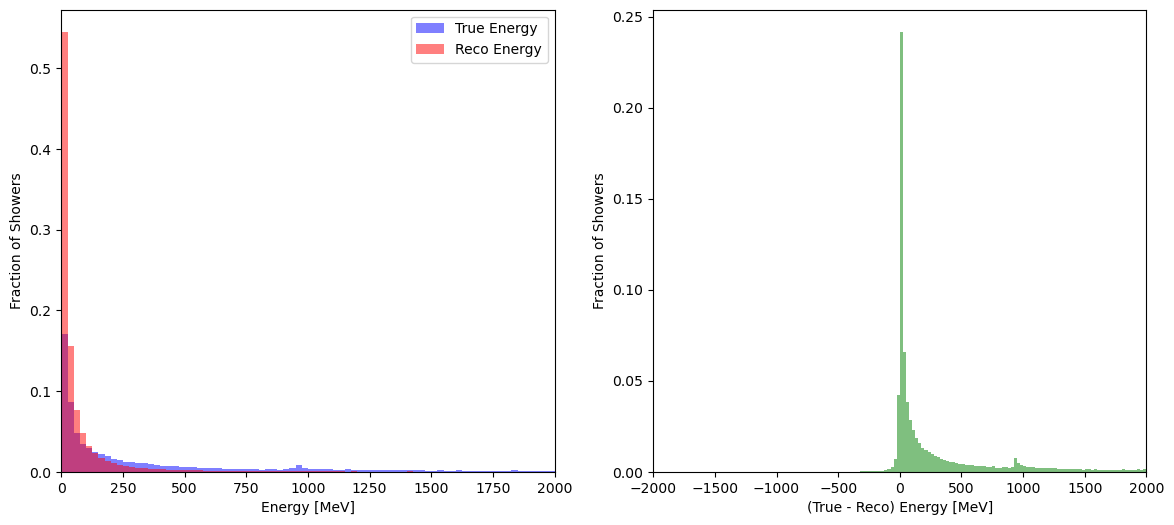

In [5]:
# Look at true vs. reco energy
fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_energy']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='True Energy', color='b')
ax[0].hist(df['reco_energy']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='Reco Energy', color='r')
ax[0].set_xlabel('Energy [MeV]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_energy']-df['reco_energy'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-2000,2000,161), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Energy [MeV]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-2000, 2000)
ax[1].set_yscale('log')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_energy']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='True Energy', color='b')
ax[0].hist(df['reco_energy']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='Reco Energy', color='r')
ax[0].set_xlabel('Energy [MeV]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 2000)
#ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_energy']-df['reco_energy'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-2000,2000,161), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Energy [MeV]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-2000, 2000)
#ax[1].set_yscale('log')
plt.show()

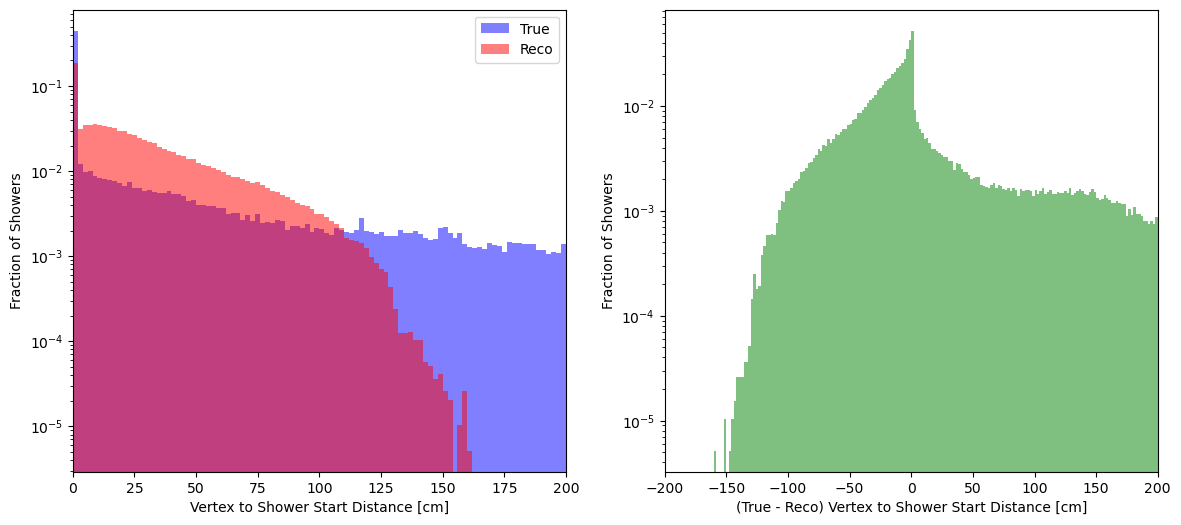

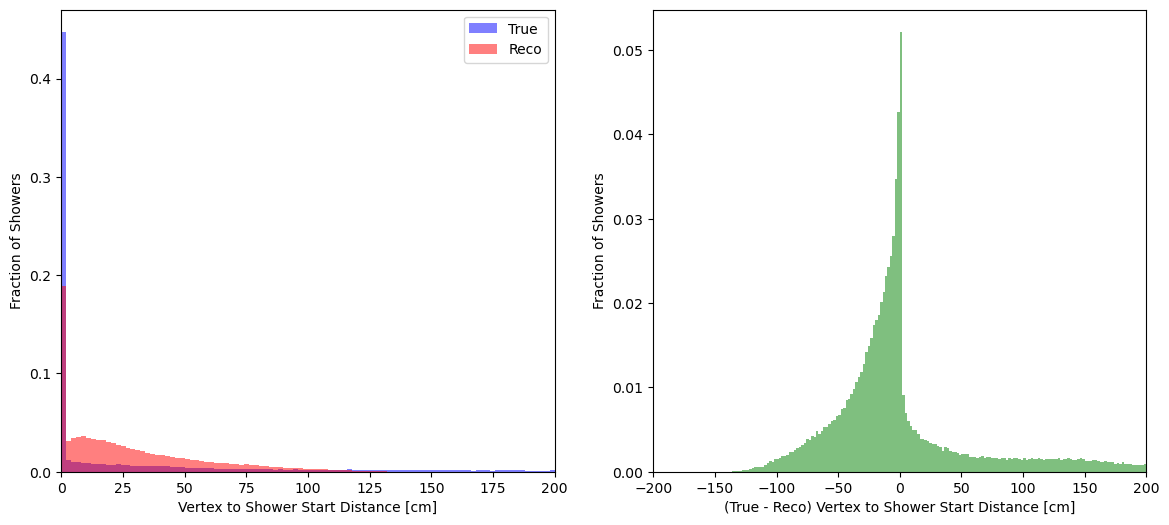

In [6]:
# Look at true vs. reco shower start to vertex distance
fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_shower_to_vtx_dist'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,200,101), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_shower_to_vtx_dist'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,200,101), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Vertex to Shower Start Distance [cm]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 200)
ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_shower_to_vtx_dist']-df['reco_shower_to_vtx_dist']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-200,200,201), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Vertex to Shower Start Distance [cm]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-200, 200)
ax[1].set_yscale('log')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_shower_to_vtx_dist'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,200,101), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_shower_to_vtx_dist'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,200,101), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Vertex to Shower Start Distance [cm]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 200)
#ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_shower_to_vtx_dist']-df['reco_shower_to_vtx_dist']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-200,200,201), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Vertex to Shower Start Distance [cm]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-200, 200)
#ax[1].set_yscale('log')
plt.show()

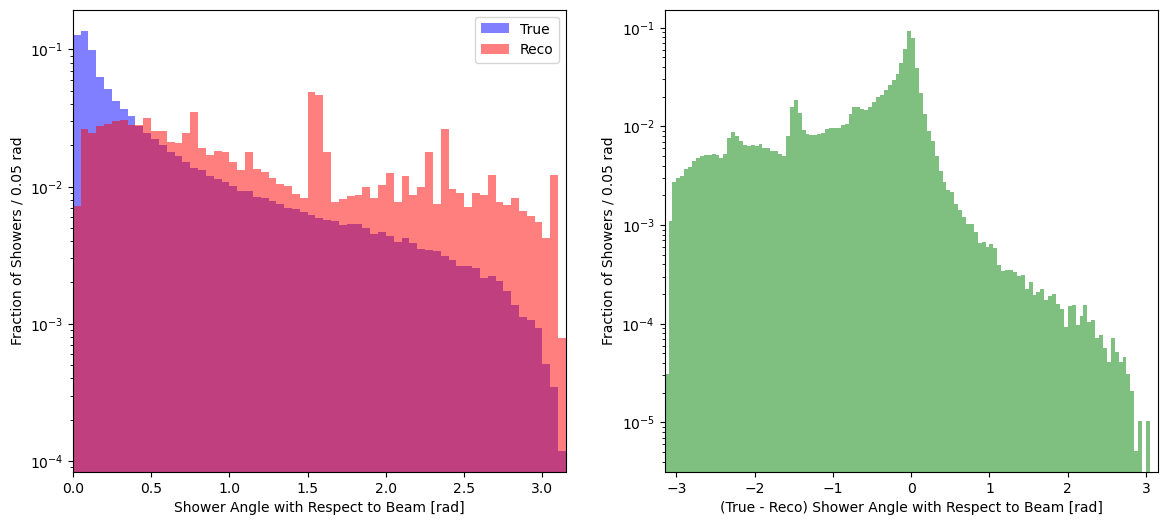

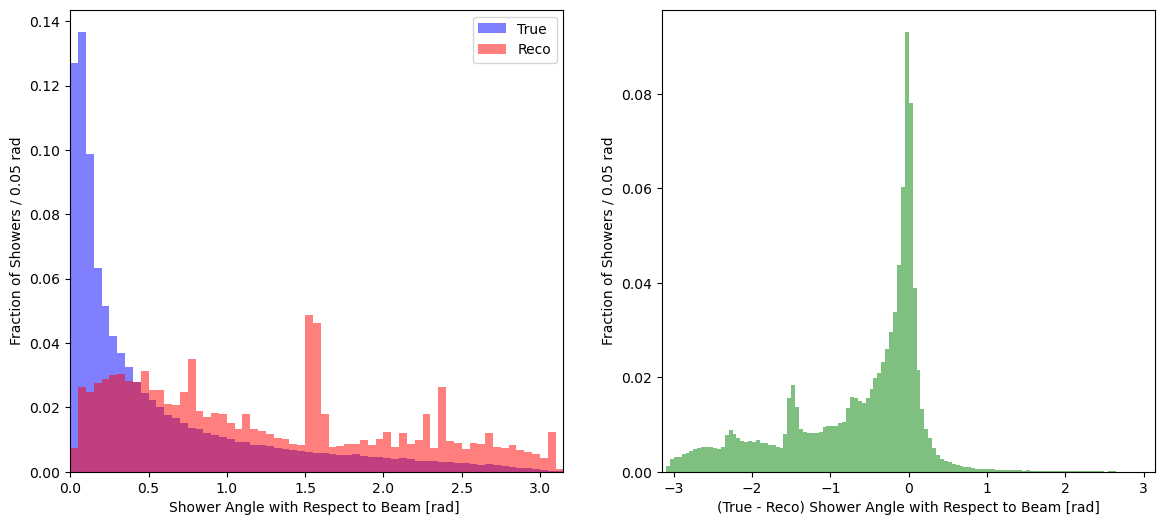

In [7]:
# Look at true vs. reco shower angle with respect to the beam
fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Shower Angle with Respect to Beam [rad]')
ax[0].set_ylabel('Fraction of Showers / 0.05 rad')
ax[0].legend()
ax[0].set_xlim(0, 3.15)
ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_angle']-df['reco_angle']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-3.15, 3.15,127), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Shower Angle with Respect to Beam [rad]')
ax[1].set_ylabel('Fraction of Showers / 0.05 rad')
ax[1].set_xlim(-3.15, 3.15)
ax[1].set_yscale('log')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Shower Angle with Respect to Beam [rad] ')
ax[0].set_ylabel('Fraction of Showers / 0.05 rad')
ax[0].legend()
ax[0].set_xlim(0, 3.15)
#ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_angle']-df['reco_angle']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-3.15, 3.15,127), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Shower Angle with Respect to Beam [rad]')
ax[1].set_ylabel('Fraction of Showers / 0.05 rad')
ax[1].set_xlim(-3.15, 3.15)
#ax[1].set_yscale('log')
plt.show()

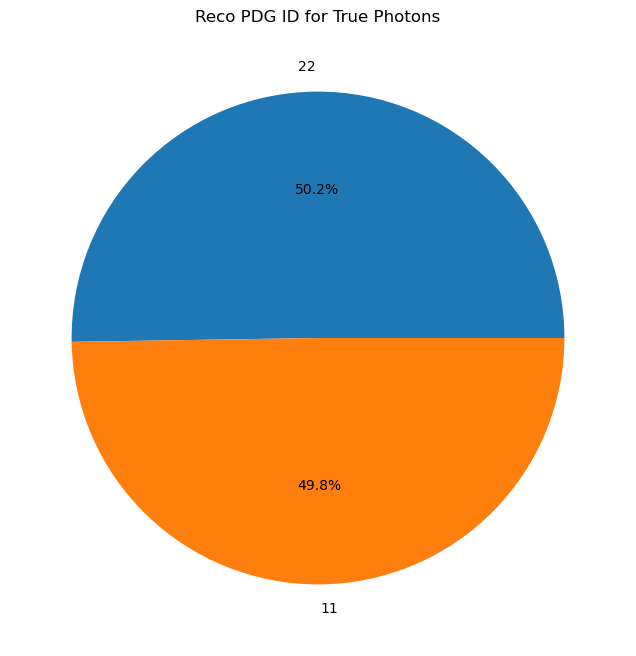

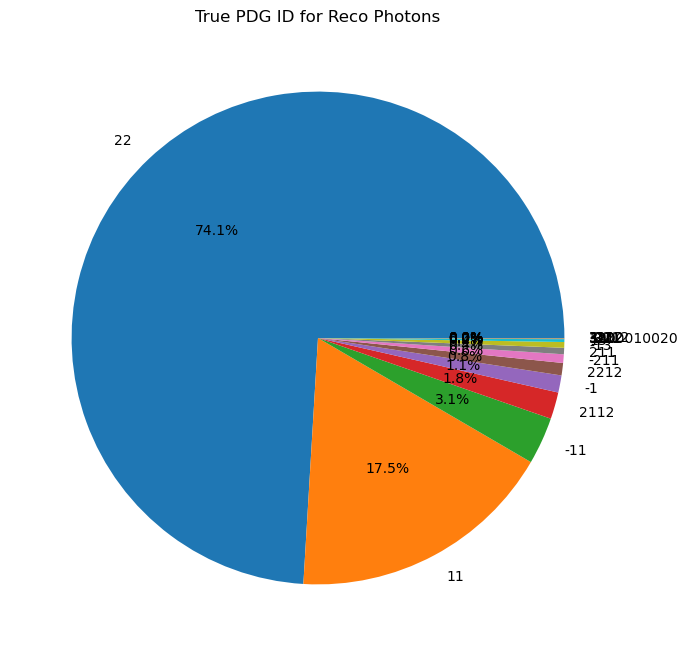

In [8]:
# Look at true vs. reco pdg
df_true_gamma = df[df['true_pdg'] == 22]
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(df_true_gamma['reco_pdg'].value_counts(), labels = df_true_gamma['reco_pdg'].value_counts().index, autopct='%1.1f%%')
ax.set_title('Reco PDG ID for True Photons')

plt.show()

df_reco_gamma = df[df['reco_pdg'] == 22]
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(df_reco_gamma['true_pdg'].value_counts(), labels = df_reco_gamma['true_pdg'].value_counts().index, autopct='%1.1f%%')
ax.set_title('True PDG ID for Reco Photons')
plt.show()

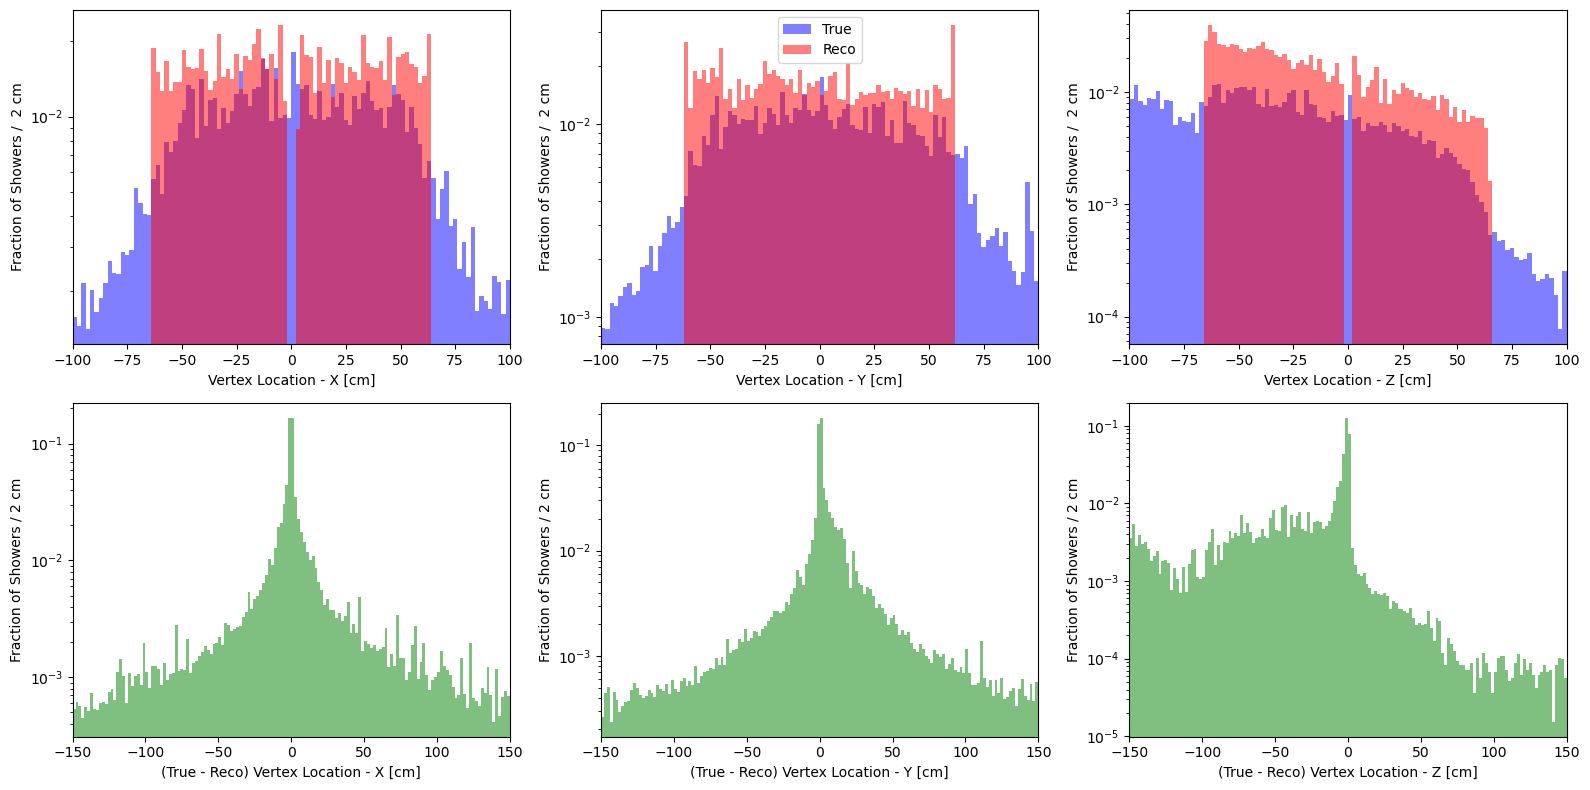

In [9]:
# Look at true vs. reco shower angle with respect to the beam
fig, ax = plt.subplots(2,3, figsize=(16, 8))
ax[0,0].hist(df['true_ixn_vtx_x_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,0].hist(df['reco_ixn_vtx_x_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,0].set_xlabel('Vertex Location - X [cm]')
ax[0,0].set_ylabel('Fraction of Showers /  2 cm')
#ax[0,0].legend()
ax[0,0].set_xlim(-100, 100)
#ax[0,0].set_ylim(0, 0.04)
ax[0,0].set_yscale('log')

# Look at true vs. reco energy
ax[1,0].hist((df['true_ixn_vtx_x_pos']-df['reco_ixn_vtx_x_pos']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,0].set_xlabel('(True - Reco) Vertex Location - X [cm]')
ax[1,0].set_ylabel('Fraction of Showers / 2 cm')
ax[1,0].set_xlim(-150, 150)
#ax[1,0].set_ylim(0, 0.19)
ax[1,0].set_yscale('log')
#plt.show()

ax[0,1].hist(df['true_ixn_vtx_y_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,1].hist(df['reco_ixn_vtx_y_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,1].set_xlabel('Vertex Location - Y [cm]')
ax[0,1].set_ylabel('Fraction of Showers /  2 cm')
ax[0,1].legend()
ax[0,1].set_xlim(-100, 100)
#ax[0,1].set_ylim(0, 0.04)
#ax[0,1].yaxis.set_visible(False) 
ax[0,1].set_yscale('log')

# Look at true vs. reco energy
ax[1,1].hist((df['true_ixn_vtx_y_pos']-df['reco_ixn_vtx_y_pos']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,1].set_xlabel('(True - Reco) Vertex Location - Y [cm]')
ax[1,1].set_ylabel('Fraction of Showers / 2 cm')
ax[1,1].set_xlim(-150, 150)
#ax[1,1].set_ylim(0, 0.19)
#ax[1,1].yaxis.set_visible(False) 
ax[1,1].set_yscale('log')

ax[0,2].hist(df['true_ixn_vtx_z_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,2].hist(df['reco_ixn_vtx_z_pos'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,2].set_xlabel('Vertex Location - Z [cm]')
ax[0,2].set_ylabel('Fraction of Showers /  2 cm')
#ax[0,2].legend()
ax[0,2].set_xlim(-100, 100)
#ax[0,2].set_ylim(0, 0.04)
#ax[0,2].yaxis.set_visible(False) 
ax[0,2].set_yscale('log')

# Look at true vs. reco energy
ax[1,2].hist((df['true_ixn_vtx_z_pos']-df['reco_ixn_vtx_z_pos']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,2].set_xlabel('(True - Reco) Vertex Location - Z [cm]')
ax[1,2].set_ylabel('Fraction of Showers / 2 cm')
ax[1,2].set_xlim(-150, 150)
#ax[1,2].set_ylim(0, 0.19)
#ax[1,2].yaxis.set_visible(False) 
ax[1,2].set_yscale('log')


plt.tight_layout()
plt.show()

#fig, ax = plt.subplots(1,2, figsize=(14, 6))
#ax[0].hist(df['true_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='True', color='b')
#ax[0].hist(df['reco_angle'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0, 3.15,64), alpha=0.5, label='Reco', color='r')
#ax[0].set_xlabel('Shower Angle with Respect to Beam [rad] ')
#ax[0].set_ylabel('Fraction of Showers / 0.05 rad')
#ax[0].legend()
#ax[0].set_xlim(0, 3.15)
##ax[0].set_yscale('log')
#
## Look at true vs. reco energy
#ax[1].hist((df['true_angle']-df['reco_angle']), weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-3.15, 3.15,127), alpha=0.5, color='g')
#ax[1].set_xlabel('(True - Reco) Shower Angle with Respect to Beam [rad]')
#ax[1].set_ylabel('Fraction of Showers / 0.05 rad')
#ax[1].set_xlim(-3.15, 3.15)
##ax[1].set_yscale('log')
#plt.show()

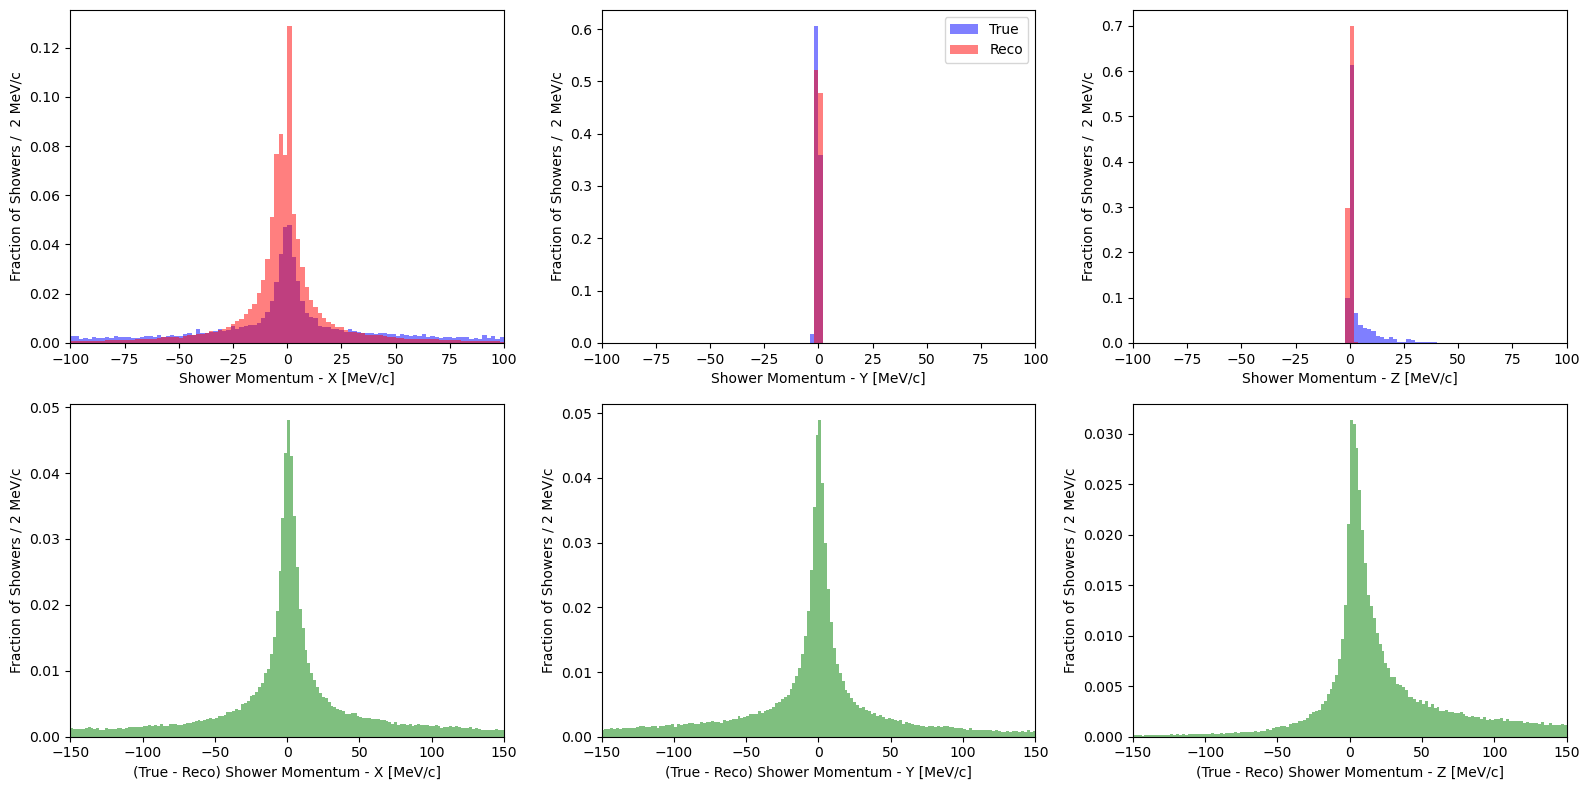

In [12]:
# Look at true vs. reco shower angle with respect to the beam
fig, ax = plt.subplots(2,3, figsize=(16, 8))
ax[0,0].hist(df['true_p_x']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,0].hist(df['reco_p_x']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,0].set_xlabel('Shower Momentum - X [MeV/c]')
ax[0,0].set_ylabel('Fraction of Showers /  2 MeV/c')
#ax[0,0].legend()
ax[0,0].set_xlim(-100, 100)
#ax[0,0].set_ylim(0, 0.04)
#ax[0,0].set_yscale('log')

# Look at true vs. reco energy
ax[1,0].hist((df['true_p_x']-df['reco_p_x'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,0].set_xlabel('(True - Reco) Shower Momentum - X [MeV/c]')
ax[1,0].set_ylabel('Fraction of Showers / 2 MeV/c')
ax[1,0].set_xlim(-150, 150)
#ax[1,0].set_ylim(0, 0.19)
#ax[1,0].set_yscale('log')
#plt.show()

ax[0,1].hist(df['true_p_y'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,1].hist(df['reco_p_y'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,1].set_xlabel('Shower Momentum - Y [MeV/c]')
ax[0,1].set_ylabel('Fraction of Showers /  2 MeV/c')
ax[0,1].legend()
ax[0,1].set_xlim(-100, 100)
#ax[0,1].set_ylim(0, 0.04)
#ax[0,1].yaxis.set_visible(False) 
#ax[0,1].set_yscale('log')

# Look at true vs. reco energy
ax[1,1].hist((df['true_p_y']-df['reco_p_y'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,1].set_xlabel('(True - Reco) Shower Momentum - Y [MeV/c]')
ax[1,1].set_ylabel('Fraction of Showers / 2 MeV/c')
ax[1,1].set_xlim(-150, 150)
#ax[1,1].set_ylim(0, 0.19)
#ax[1,1].yaxis.set_visible(False) 
#ax[1,1].set_yscale('log')

ax[0,2].hist(df['true_p_z'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='True', color='b')
ax[0,2].hist(df['reco_p_z'], weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-100, 100,101), alpha=0.5, label='Reco', color='r')
ax[0,2].set_xlabel('Shower Momentum - Z [MeV/c]')
ax[0,2].set_ylabel('Fraction of Showers /  2 MeV/c')
#ax[0,2].legend()
ax[0,2].set_xlim(-100, 100)
#ax[0,2].set_ylim(0, 0.04)
#ax[0,2].yaxis.set_visible(False) 
#ax[0,2].set_yscale('log')

# Look at true vs. reco energy
ax[1,2].hist((df['true_p_z']-df['reco_p_z'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-150, 150,151), alpha=0.5, color='g')
ax[1,2].set_xlabel('(True - Reco) Shower Momentum - Z [MeV/c]')
ax[1,2].set_ylabel('Fraction of Showers / 2 MeV/c')
ax[1,2].set_xlim(-150, 150)
#ax[1,2].set_ylim(0, 0.19)
#ax[1,2].yaxis.set_visible(False) 
#ax[1,2].set_yscale('log')


plt.tight_layout()
plt.show()


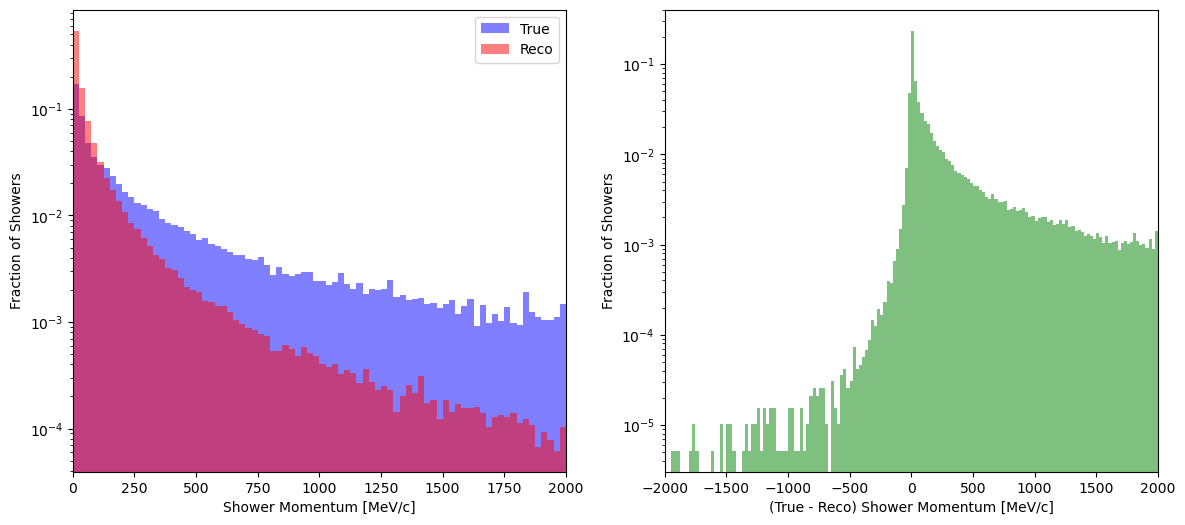

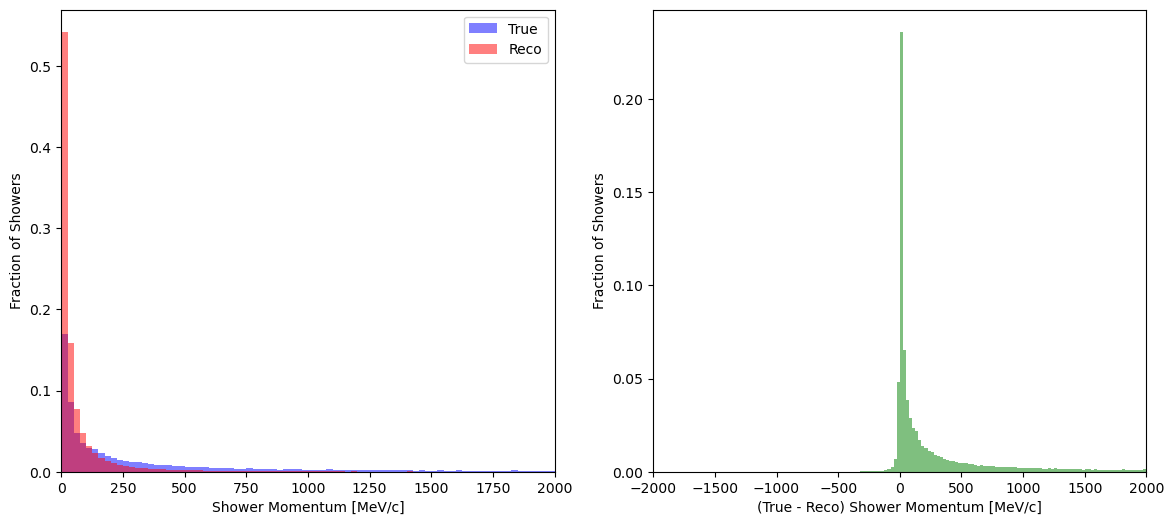

In [13]:
# Look at true vs. reco energy
fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_p_mag']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_p_mag']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Shower Momentum [MeV/c]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_yscale('log')

# Look at true vs. reco energy
ax[1].hist((df['true_p_mag']-df['reco_p_mag'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-2000,2000,161), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Shower Momentum [MeV/c]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-2000, 2000)
ax[1].set_yscale('log')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].hist(df['true_p_mag']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='True', color='b')
ax[0].hist(df['reco_p_mag']*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(0,2000,81), alpha=0.5, label='Reco', color='r')
ax[0].set_xlabel('Shower Momentum [MeV/c]')
ax[0].set_ylabel('Fraction of Showers')
ax[0].legend()
ax[0].set_xlim(0, 2000)

# Look at true vs. reco energy
ax[1].hist((df['true_p_mag']-df['reco_p_mag'])*1000, weights=np.full(num_entries, 1/num_entries), bins=np.linspace(-2000,2000,161), alpha=0.5, color='g')
ax[1].set_xlabel('(True - Reco) Shower Momentum [MeV/c]')
ax[1].set_ylabel('Fraction of Showers')
ax[1].set_xlim(-2000, 2000)
plt.show()